#**Select Categorical Input Features**

#What is Feature Selection?
Feature selection is the process of identifying and selecting a subset of input features that are
most relevant to the target variable. Feature selection is often straightforward when working
with real-valued data, such as using the Pearson's correlation coefficient, but can be challenging
when working with categorical data. The two most commonly used feature selection methods for
categorical input data when the target variable is also categorical (e.g. classification predictive
modeling) are the chi-squared statistic and the mutual information statistic.

In this tutorial,
you will discover how to perform feature selection with categorical input data. After completing
this tutorial, you will learn:
* The breast cancer predictive modeling problem with categorical inputs and binary classification target variable.
* How to evaluate the importance of categorical features using the chi-squared and mutual
information statistics.
* How to perform feature selection for categorical data when      fitting and evaluating a
classification model.

Adapted from Jason Brownlee. 2020. [Data Preparation for Machine Learning](https://machinelearningmastery.com/data-preparation-for-machine-learning/).



##Breast Cancer Dataset
Breast cancer dataset classifies breast cancer
patient data as either a recurrence or no recurrence of cancer. 

```
Number of Instances: 286
Number of Attributes: 9 + the class attribute
Attribute Information:
   1. Class: no-recurrence-events, recurrence-events
   2. age: 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99.
   3. menopause: lt40, ge40, premeno.
   4. tumor-size: 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59.
   5. inv-nodes: 0-2, 3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23, 24-26, 27-29, 30-32, 33-35, 36-39.
   6. node-caps: yes, no.
   7. deg-malig: 1, 2, 3.
   8. breast: left, right.
   9. breast-quad: left-up, left-low, right-up,	right-low, central.
  10. irradiat:	yes, no.
Missing Attribute Values: (denoted by "?")
   Attribute #:  Number of instances with missing values:
   6.             8
   9.             1.
Class Distribution:
    1. no-recurrence-events: 201 instances
    2. recurrence-events: 85 instances 
```

You can learn more about the dataset here:
* Breast Cancer Dataset ([breast-cancer.csv](https://raw.githubusercontent.com/jbrownlee/Datasets/master/breast-cancer.csv))
* Breast Cancer Dataset Description ([breast-cancer.names](https://raw.githubusercontent.com/jbrownlee/Datasets/master/breast-cancer.names))



###Download Breast Cancer data files

In [ ]:
!wget "https://raw.githubusercontent.com/jbrownlee/Datasets/master/breast-cancer.csv" -O breast-cancer.csv
!wget "https://raw.githubusercontent.com/jbrownlee/Datasets/master/breast-cancer.names" -O breast-cancer.names
!head breast-cancer.csv

--2022-06-08 02:29:15--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/breast-cancer.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24373 (24K) [text/plain]
Saving to: ‘breast-cancer.csv’

breast-cancer.csv   100%[===================>]  23.80K  --.-KB/s    in 0.002s  

2022-06-08 02:29:15 (9.46 MB/s) - ‘breast-cancer.csv’ saved [24373/24373]

--2022-06-08 02:29:15--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/breast-cancer.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3162 (3.1K) [text/p

###Loading and encoding the categorical dataset

In [ ]:
# example of loading and preparing the breast cancer dataset
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

# load the dataset
def load_dataset(filename):
  # load the dataset
  dataset = read_csv(filename, header=None)
  # retrieve array
  data = dataset.values
  # split into input and output variables
  X = data[:, :-1]
  y = data[:,-1]
  # format all fields as string
  X = X.astype(str)
  return X, y

# prepare input data
def prepare_inputs(X_train, X_test):
  oe = OrdinalEncoder() # encode each variable to integers
  oe.fit(X_train)
  X_train_enc = oe.transform(X_train)
  X_test_enc = oe.transform(X_test)
  return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
  le = LabelEncoder() # LabelEncoder is designed for encoding a single variable
  le.fit(y_train)
  y_train_enc = le.transform(y_train)
  y_test_enc = le.transform(y_test)
  return y_train_enc, y_test_enc
  
# load the dataset
X, y = load_dataset('breast-cancer.csv')
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# summarize
print('Train', X_train_enc.shape, y_train_enc.shape)
print('Test', X_test_enc.shape, y_test_enc.shape)

Train (191, 9) (191,)
Test (95, 9) (95,)


We can see that we have 191 examples for training and 95 for testing.

##Categorical Feature Selection
There are two popular feature selection techniques that can be used for categorical input data
and a categorical (class) target variable. They are:
* Chi-Squared Statistic.
* Mutual Information Statistic.



###**Chi-Squared Feature Selection**
Pearson's chi-squared statistical hypothesis
test is an example of a test for independence between categorical variables. The results of this
test can be used for feature selection, where those features that are independent of the target
variable can be removed from the dataset.

In [ ]:
# example of chi squared feature selection for categorical data
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from matplotlib import pyplot

# load the dataset
def load_dataset(filename):
  # load the dataset as a pandas DataFrame
  dataset = read_csv(filename, header=None)
  # retrieve numpy array
  data = dataset.values
  # split into input (X) and output (y) variables
  X = data[:, :-1]
  y = data[:,-1]
  # format all fields as string
  X = X.astype(str)
  return X, y

# prepare input data
def prepare_inputs(X_train, X_test):
  oe = OrdinalEncoder()
  oe.fit(X_train)
  X_train_enc = oe.transform(X_train)
  X_test_enc = oe.transform(X_test)
  return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
  le = LabelEncoder()
  le.fit(y_train)
  y_train_enc = le.transform(y_train)
  y_test_enc = le.transform(y_test)
  return y_train_enc, y_test_enc
  
# feature selection
def select_features(X_train, y_train, X_test):
  # Select features according to the k highest scores.
  fs = SelectKBest(score_func=chi2, k='all')
  fs.fit(X_train, y_train)
  # Reduce X to the selected features.
  X_train_fs = fs.transform(X_train)
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs, fs

# load the dataset
X, y = load_dataset('breast-cancer.csv')
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
# what are scores for the features
for i in range(len(fs.scores_)):
  print('Feature %d: %f' % (i, fs.scores_[i]))


Feature 0: 0.472553
Feature 1: 0.029193
Feature 2: 2.137658
Feature 3: 29.381059
Feature 4: 8.222601
Feature 5: 8.100183
Feature 6: 1.273822
Feature 7: 0.950682
Feature 8: 3.699989


In this case, we can see the scores are small and it is hard to get an idea from the number
alone as to which features are more relevant. Perhaps features 3, 4, 5, and 8 are most relevant.

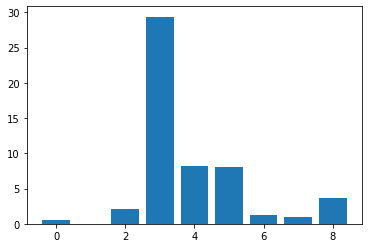

In [ ]:
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

A bar chart of the feature importance scores for each input feature is created. This clearly
shows that feature 3 might be the most relevant (according to chi-squared) and that perhaps
four of the nine input features are the most relevant. We could set k = 4 when configuring the
SelectKBest to select these top four features.

###**Mutual Information Feature Selection**
Mutual information from the field of information theory is the application of information gain
(typically used in the construction of decision trees) to feature selection. Mutual information is
calculated between two variables and measures the reduction in uncertainty for one variable
given a known value of the other variable.

In [ ]:
# example of mutual information feature selection for categorical data
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from matplotlib import pyplot
# load the dataset
def load_dataset(filename):
  # load the dataset as a pandas DataFrame
  dataset = read_csv(filename, header=None)
  # retrieve numpy array
  data = dataset.values
  # split into input (X) and output (y) variables
  X = data[:, :-1]
  y = data[:,-1]
  # format all fields as string
  X = X.astype(str)
  return X, y

# prepare input data
def prepare_inputs(X_train, X_test):
  oe = OrdinalEncoder()
  oe.fit(X_train)
  X_train_enc = oe.transform(X_train)
  X_test_enc = oe.transform(X_test)
  return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
  le = LabelEncoder()
  le.fit(y_train)
  y_train_enc = le.transform(y_train)
  y_test_enc = le.transform(y_test)
  return y_train_enc, y_test_enc
  
# feature selection
def select_features(X_train, y_train, X_test):
  fs = SelectKBest(score_func=mutual_info_classif, k='all')
  fs.fit(X_train, y_train)
  X_train_fs = fs.transform(X_train)
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs, fs

# load the dataset
X, y = load_dataset('breast-cancer.csv')
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
# what are scores for the features
for i in range(len(fs.scores_)):
  print('Feature %d: %f' % (i, fs.scores_[i]))


Feature 0: 0.000000
Feature 1: 0.000000
Feature 2: 0.057456
Feature 3: 0.053555
Feature 4: 0.007327
Feature 5: 0.052219
Feature 6: 0.000000
Feature 7: 0.000000
Feature 8: 0.000000


In this case, we can see that some of the features have a very low score, suggesting that
perhaps they can be removed.

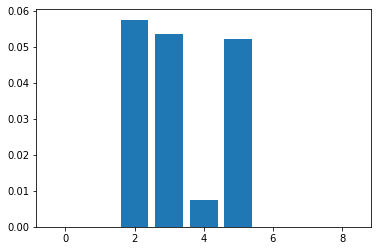

In [ ]:
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

A bar chart of the feature importance scores for each input feature is created. Importantly,
a different mixture of features is promoted.

##Modeling With Selected Features
A robust approach is to evaluate models using different
feature selection methods (and numbers of features) and select the method that results in a
model with the best performance. We will evaluate a Logistic Regression model
with all features compared to a model built from features selected by chi-squared and those
features selected via mutual information. Logistic regression is a good model for testing feature
selection methods as it can perform better if irrelevant features are removed from the model.



###**Model Built Using All Features**

In [ ]:
# evaluation of a model using all input features
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# load the dataset
def load_dataset(filename):
  # load the dataset as a pandas DataFrame
  dataset = read_csv(filename, header=None)
  # retrieve numpy array
  data = dataset.values
  # split into input (X) and output (y) variables
  X = data[:, :-1]
  y = data[:,-1]
  # format all fields as string
  X = X.astype(str)
  return X, y

# prepare input data
def prepare_inputs(X_train, X_test):
  oe = OrdinalEncoder()
  oe.fit(X_train)
  X_train_enc = oe.transform(X_train)
  X_test_enc = oe.transform(X_test)
  return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
  le = LabelEncoder()
  le.fit(y_train)
  y_train_enc = le.transform(y_train)
  y_test_enc = le.transform(y_test)
  return y_train_enc, y_test_enc

# load the dataset
X, y = load_dataset('breast-cancer.csv')
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_enc, y_train_enc)
# evaluate the model
yhat = model.predict(X_test_enc)
# evaluate predictions
accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 75.79


In this case, we can see that the model achieves a classification accuracy of about 75 percent.
We would prefer to use a subset of features that achieves a classification accuracy that is as
good or better than this.

###**Model Built Using Chi-Squared Features**

In [ ]:
# evaluation of a model fit using chi squared input features
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# load the dataset
def load_dataset(filename):
  # load the dataset as a pandas DataFrame
  dataset = read_csv(filename, header=None)
  # retrieve numpy array
  data = dataset.values
  # split into input (X) and output (y) variables
  X = data[:, :-1]
  y = data[:,-1]
  # format all fields as string
  X = X.astype(str)
  return X, y

# prepare input data
def prepare_inputs(X_train, X_test):
  oe = OrdinalEncoder()
  oe.fit(X_train)
  X_train_enc = oe.transform(X_train)
  X_test_enc = oe.transform(X_test)
  return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
  le = LabelEncoder()
  le.fit(y_train)
  y_train_enc = le.transform(y_train)
  y_test_enc = le.transform(y_test)
  return y_train_enc, y_test_enc

# feature selection
def select_features(X_train, y_train, X_test):
  fs = SelectKBest(score_func=chi2, k=4)
  fs.fit(X_train, y_train)
  X_train_fs = fs.transform(X_train)
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs

# load the dataset
X, y = load_dataset('breast-cancer.csv')
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# feature selection
X_train_fs, X_test_fs = select_features(X_train_enc, y_train_enc, X_test_enc)
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_fs, y_train_enc)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 74.74


In this case, we see that the model achieved an accuracy of about 74 percent, a slight drop in
performance. It is possible that some of the features removed are, in fact, adding value directly
or in concert with the selected features. At this stage, we would probably prefer to use all of
the input features.

###**Model Built Using Mutual Information Features**

In [ ]:
# evaluation of a model fit using mutual information input features
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# load the dataset
def load_dataset(filename):
  # load the dataset as a pandas DataFrame
  dataset = read_csv(filename, header=None)
  # retrieve numpy array
  data = dataset.values
  # split into input (X) and output (y) variables
  X = data[:, :-1]
  y = data[:,-1]
  # format all fields as string
  X = X.astype(str)
  return X, y

# prepare input data
def prepare_inputs(X_train, X_test):
  oe = OrdinalEncoder()
  oe.fit(X_train)
  X_train_enc = oe.transform(X_train)
  X_test_enc = oe.transform(X_test)
  return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
  le = LabelEncoder()
  le.fit(y_train)
  y_train_enc = le.transform(y_train)
  y_test_enc = le.transform(y_test)
  return y_train_enc, y_test_enc

# feature selection
def select_features(X_train, y_train, X_test):
  fs = SelectKBest(score_func=mutual_info_classif, k=4)
  fs.fit(X_train, y_train)
  X_train_fs = fs.transform(X_train)
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs

# load the dataset
X, y = load_dataset('breast-cancer.csv')
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# feature selection
X_train_fs, X_test_fs = select_features(X_train_enc, y_train_enc, X_test_enc)
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_fs, y_train_enc)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 64.21


In this case, we can see drop in classification accuracy. To be sure that
the effect is real, it would be a good idea to repeat each experiment multiple times and compare
the mean performance. It may also be a good idea to explore using k-fold cross-validation
instead of a simple train/test split.